In [1]:
import torch
import numpy as np 
from gpssm.models.gp import ExactGPModel, VariationalGP
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def plot_predictions(train_x, train_y, test_x, pred_y):
    fig, axes = plt.subplots(dim_y, 1, figsize=(8,8))
    for i in range(dim_y):
        lower, upper = pred_y.confidence_region()
        lower = lower.detach()
        upper = upper.detach()
        axes[i].plot(train_x[:, 0], train_y[i], 'k*')

        idx = test_x[:, 0].argsort()
        axes[i].plot(test_x[idx, 0], pred_y.mean[i, idx], 'b')
        axes[i].fill_between(test_x[idx, 0], lower[i, idx], upper[i, idx], alpha=0.5)

        axes[i].legend(['Observed Data', 'Mean', 'Confidence'])
        axes[i].set_title('Observed Values (Likelihood)')

        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y_{}'.format(i))
    plt.show()
    
def plot_losses(losses):
    plt.figure(figsize=(8, 4))
    plt.plot(losses, 'k-')
    plt.xlabel('Iteration Number')
    plt.ylabel('Marginal Log-Likelihood')
    plt.show()

# Generate data

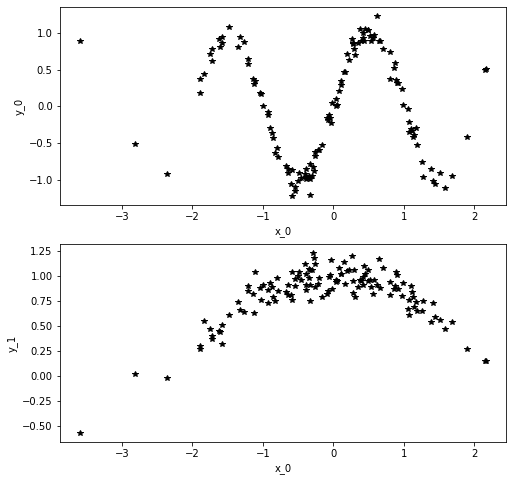

In [3]:
dim_x, dim_u = 2, 1
dim_y = dim_x
num_points = 128
decoupled_outputs = True
batch_size = dim_y if decoupled_outputs else 1
xu = torch.randn((num_points, dim_x + dim_u))

y1 = (torch.sin(np.pi * xu[:, 0]) + 0 * xu[:, 2] - 0 * xu[:, 1] ** 2).unsqueeze(dim=1)
y2 = (torch.cos(np.pi / 5 * xu[:, 0]) - 0 * xu[:, 2] ** 2 + 0 * xu[:, 1]).unsqueeze(dim=1)
y = torch.cat((y1, y2), dim=-1) + 0.1 * torch.randn((num_points, dim_y))

y = y[:, :dim_y]
y = y.t()

train_xu, test_xu = xu[:(num_points // 2)], xu[(num_points // 2):]
train_y, test_y = y[:, :(num_points // 2)], y[:, (num_points // 2):]

fig, axes = plt.subplots(dim_y, 1, figsize=(8,8))
for i in range(dim_y):
    axes[i].plot(xu[:, 0], y[i], 'k*')
    axes[i].set_xlabel('x_0')
    axes[i].set_ylabel('y_{}'.format(i))
    
plt.show()

# Exact GP Model 
 

In [4]:
# Set up likelihood, mean, and Kernel functions.
# likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(0.01, 0.02), batch_size=dim_y)
# mean = ConstantMean(batch_size=dim_y)
# kernel = ScaleKernel(RBFKernel(ard_num_dims=dim_x + dim_u, batch_size=dim_y), batch_size=dim_y)

likelihood = GaussianLikelihood(
    batch_size=batch_size
    # noise_prior=gpytorch.priors.NormalPrior(0.1, 0.1)
)
mean = ConstantMean(batch_size=batch_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dim_x + dim_u, 
                               batch_size=batch_size
                               # lengthscale_prior=gpytorch.priors.GammaPrior(0.01, 0.1)
                               ),
                     batch_size=batch_size
                     # outputscale_prior=gpytorch.priors.GammaPrior(0.2, 0.2)
                     )


# Initialize Model, Marginal Log-Likelihood, and Optimizer.
model = ExactGPModel(train_xu, train_y, likelihood, mean, kernel)
mll = ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters.
], lr=0.1)

def train(training_iter):
    # Set model and likelihood to training mode.
    model.train()
    likelihood.train()
    losses = []

    for i in range(training_iter):
        # Zero gradients from previous iteration.
        optimizer.zero_grad()

        # Output from model.
        pred_f = model(train_xu)

        # Calc loss and backprop gradients.
        loss = -mll(pred_f, train_y).sum()
        loss.backward()
        losses.append(loss.item())
        
        if i % 50 == 0:
            print('Iter {}/{} - Loss: {}'.format(i + 1, training_iter, loss.item()))
        optimizer.step()
    
    return losses 

def eval(test_x, test_y):
    # Set model and likelihood to evaluation mode.
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred_f = model(test_x) #.expand(dim_y, *test_data.shape))
        loss = -mll(pred_f, test_y).sum()
        pred_y = likelihood(pred_f)
        print('MLL call:', loss.item()) 
        print('Direct Computation:', -pred_y.log_prob(test_y).sum().item() / (num_points // 2))
    return likelihood(pred_f)
        
losses = train(200)
pred_y = eval(test_xu, test_y)

print(
    likelihood.noise_covar.noise.detach(),
    model.covar_module.outputscale.detach(),
    model.covar_module.base_kernel.lengthscale.detach(),
)

Iter 1/200 - Loss: 2.2750067710876465
Iter 51/200 - Loss: -0.8495559692382812
Iter 101/200 - Loss: -0.9508135318756104
Iter 151/200 - Loss: -0.9915875196456909
MLL call: -1.4071848392486572
Direct Computation: -1.4071848392486572
tensor([[0.0087],
        [0.0108]]) tensor([0.4700, 0.1103]) tensor([[[ 0.5038, 10.0190,  9.2608]],

        [[ 1.0154,  9.1972,  8.0297]]])


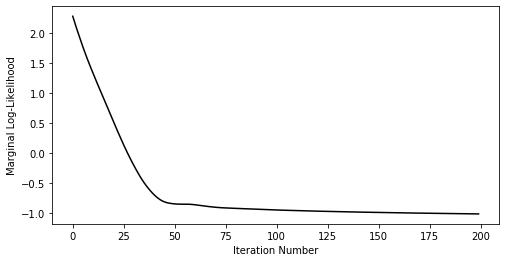

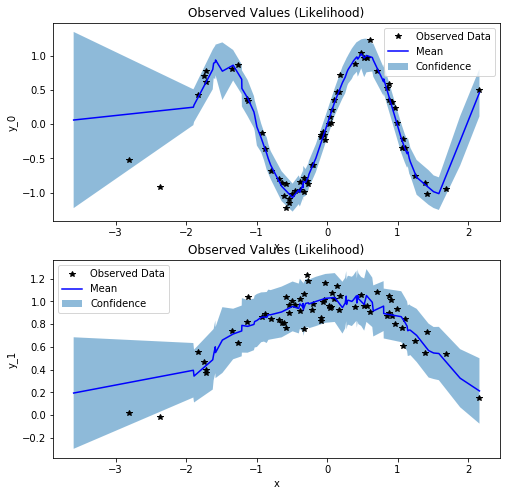

In [5]:
plot_losses(losses)
plot_predictions(train_xu, train_y, test_xu, pred_y)

# Variational GP Model 

In [6]:
num_inducing_points = 25
learn_inducing_loc = False
# inducing_points = torch.linspace(-2, 2, num_inducing_points).unsqueeze(-1).repeat(dim_y, 1, dim_x + dim_u)
inducing_points = torch.randn((dim_y, num_inducing_points, dim_x + dim_u))
# noise = torch.tensor([0.1]).expand(dim_y, 1, 1)
# print(noise.shape)
likelihood = GaussianLikelihood(
    batch_size=batch_size,
    # noise=noise
    # noise_prior=gpytorch.priors.GammaPrior(mean ** 2 / var, mean / var)
)
mean = ConstantMean(batch_size=batch_size,)
kernel = ScaleKernel(RBFKernel(
                                ard_num_dims=dim_x + dim_u, 
                               batch_size=batch_size,
                               # lengthscale_prior=gpytorch.priors.GammaPrior(0.01, 0.1)
                               ),
                     # outputscale_prior=gpytorch.priors.GammaPrior(10, 10),
                     batch_size=batch_size,
                     )
model = VariationalGP(inducing_points, mean, kernel, learn_inducing_loc)

# hypers = {
#     # 'likelihood.noise_covar.noise': torch.tensor(1.),
#     'covar_module.base_kernel.lengthscale': torch.tensor(0.05),
#     'covar_module.outputscale': torch.tensor(1.),
# }
# 
# model.initialize(**hypers)
# likelihood.initialize(**{'noise_covar.noise': torch.tensor(0.1)})

print(
    likelihood.noise_covar.noise.detach(),
    model.covar_module.outputscale.detach(),
    model.covar_module.base_kernel.lengthscale.detach(),
)

optimizer = torch.optim.Adam([
    {'params': model.parameters()}, # Does not include gaussian likelihood.
    {'params': likelihood.parameters()} 
], lr=0.01)

mll = VariationalELBO(likelihood, model, train_y.size(-1), combine_terms=False)

def train(training_iter):
    # Set model and likelihood to training mode.
    model.train()
    likelihood.train()
    losses = []
    
    for i in range(training_iter):
        # Zero gradients from previous iteration.
        optimizer.zero_grad()
        
        # Output from model.
        output = model(train_xu)
        
        # Calc loss and backprop gradients
        log_lik, kl_div, log_prior = mll(output, train_y)
        loss = -(log_lik - kl_div + log_prior).mean()
        loss.backward()
        losses.append(loss.item())
        
        if i % 50 == 0:
            print('Iter %d - Loss: %.3f [%.3f, %.3f, %.3f]' % (
                i + 1, loss.item(), log_lik.mean().item(), kl_div.mean().item(),
                log_prior.mean().item()))
        optimizer.step()
    return losses 
        
# EVALUATE!
def eval(test_x, test_y):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_computations():
        pred_f = model(test_x) #test_x.expand(dim_y, *test_x.shape))
        pred_y = likelihood(pred_f)
        log_lik, kl_div, log_prior = mll(pred_f, test_y)
        loss = -(log_lik - kl_div + log_prior).mean()
        print('MLL call:', loss.item(), log_lik.detach(), kl_div.detach(),
              log_prior.detach())

        print('Direct Computation:', likelihood.expected_log_prob(test_y, pred_f).detach() / (num_points // 2))
        print('ExactLogLikelihood', likelihood(pred_f).log_prob(test_y).detach() / (num_points // 2))
        
        print('KL Divergence:', model.variational_strategy.kl_divergence() / (num_points // 2))
    
    return pred_y

losses = train(200)
pred_y = eval(test_xu, test_y)

tensor([[0.6932],
        [0.6932]]) tensor([0.6931, 0.6931]) tensor([[[0.6931, 0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931]]])
Iter 1 - Loss: 1.693 [-1.693, 0.000, 0.000]
Iter 51 - Loss: 1.192 [-1.141, 0.052, 0.000]
Iter 101 - Loss: 0.934 [-0.853, 0.081, 0.000]
Iter 151 - Loss: 0.639 [-0.517, 0.122, 0.000]
MLL call: 0.49328145384788513 tensor([-0.4671, -0.1854]) tensor([0.2409, 0.0932]) tensor([0., 0.])
Direct Computation: tensor([-0.4671, -0.1854])
ExactLogLikelihood tensor([-0.2798, -0.1351])
KL Divergence: tensor([0.2409, 0.0932])


/Users/sebascuri/anaconda3/envs/gpssm/lib/python3.6/site-packages/gpytorch/lazy/cached_cg_lazy_tensor.py:142: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([2, 25, 26]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning


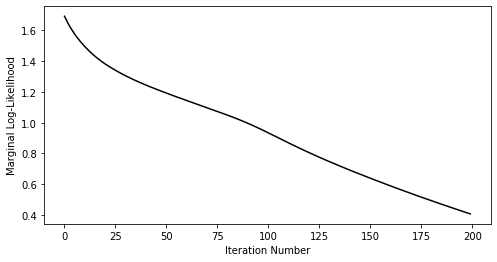

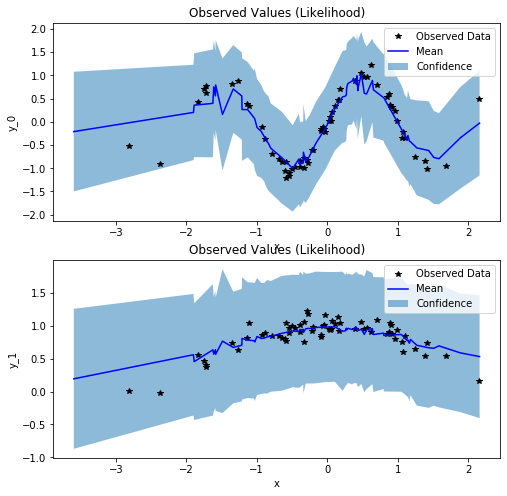

In [7]:
plot_losses(losses)
plot_predictions(train_xu, train_y, test_xu, pred_y)

# Sample Exact GP from Variational GP


In [8]:
sampled_model = model.sample_gp(likelihood)
sampled_model.eval()
likelihood.eval()

mll = ExactMarginalLogLikelihood(likelihood, sampled_model)

def eval(test_x, test_y):
    # Set model and likelihood to evaluation mode.
    sampled_model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred_f = sampled_model(test_x) 
        pred_y = likelihood(pred_f)
        loss = -mll(pred_f, test_y).sum()
        print('MLL call:', loss.item()) 
        print('Direct Computation:', -pred_y.log_prob(test_y).sum().item() / (num_points // 2))
    return pred_y

pred_y = eval(test_xu, test_y)

MLL call: 0.5567588210105896
Direct Computation: 0.5567588210105896


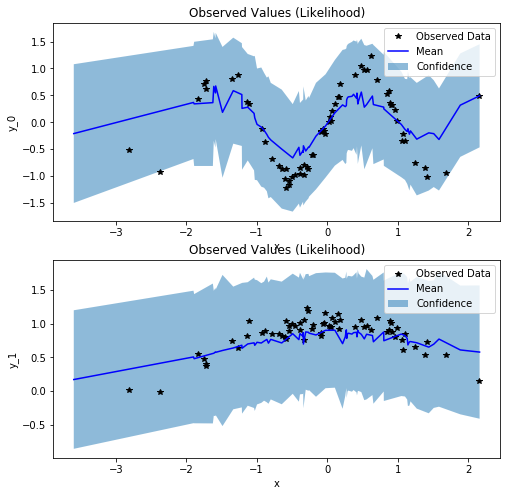

In [9]:
plot_predictions(train_xu, train_y, test_xu, pred_y)